In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image_dataset_from_directory
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
print(f"TensorFlow: {tf.__version__}")
print("✅ Setup complete!")


TensorFlow: 2.20.0
✅ Setup complete!


In [2]:
# Your dataset path
DATASET_DIR = r"C:\Users\chinm\Downloads\Indian Medicinal Leaves Image Datasets\Medicinal Leaf dataset_cleaned2"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 1e-4

print(f"📁 Dataset: {DATASET_DIR}")
print(f"🖼️  Image Size: {IMG_SIZE}")
print(f"📦 Batch Size: {BATCH_SIZE}")


📁 Dataset: C:\Users\chinm\Downloads\Indian Medicinal Leaves Image Datasets\Medicinal Leaf dataset_cleaned2
🖼️  Image Size: (224, 224)
📦 Batch Size: 32


Found 6900 files belonging to 80 classes.
Using 5520 files for training.
Found 6900 files belonging to 80 classes.
Using 1380 files for validation.
✅ Found 80 classes: ['Aloevera', 'Amla', 'Amruthaballi', 'Arali', 'Astma_weed']...
📊 Train batches: 173, Val batches: 44


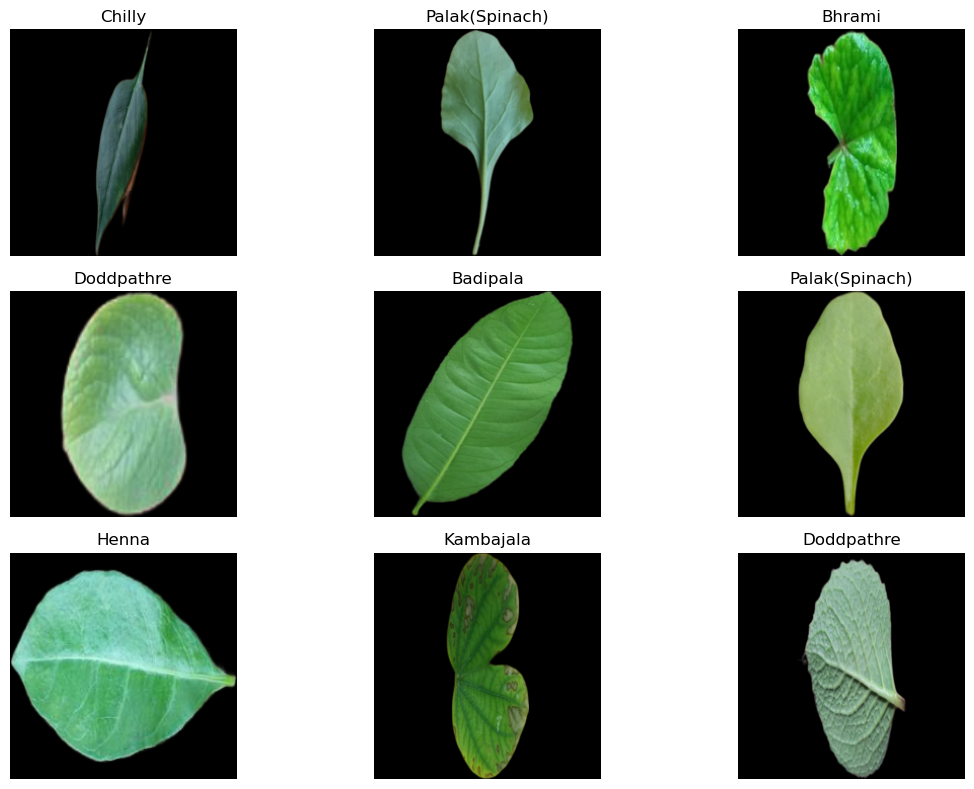

In [3]:
# Load train/validation datasets
train_ds = image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)

print(f"✅ Found {NUM_CLASSES} classes: {class_names[:5]}...")
print(f"📊 Train batches: {len(train_ds)}, Val batches: {len(val_ds)}")

# Visualize sample images
plt.figure(figsize=(12, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()
plt.show()


In [4]:
AUTOTUNE = tf.data.AUTOTUNE

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

def preprocess_data(image, label):
    image = data_augmentation(image, training=True)
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image, label

# Apply preprocessing
train_ds = train_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(
    lambda x, y: (tf.keras.applications.efficientnet.preprocess_input(x), y),
    num_parallel_calls=AUTOTUNE
)

# Optimize pipeline
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

print("✅ Data pipeline ready!")


✅ Data pipeline ready!


In [5]:
# FUNCTIONAL API - NO SERIALIZATION BUGS!
inputs = layers.Input(shape=(224, 224, 3))
base_model = EfficientNetB0(
    weights="imagenet", 
    include_top=False, 
    input_tensor=inputs
)
base_model.trainable = False  # Freeze base

# Classifier head
x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
x = layers.BatchNormalization(name="batch_norm")(x)
x = layers.Dense(256, activation="relu", name="dense_1")(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(
    NUM_CLASSES, 
    activation="softmax", 
    dtype="float32", 
    name="predictions"
)(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 224, 224, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 224, 224, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 4,403,187 (16.80 MB)

 Trainable params: 351,056 (1.34 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [6]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy', 
        patience=5, 
        restore_best_weights=True
    ),
    ModelCheckpoint(
        "best_model.keras",
        monitor='val_accuracy',
        save_best_only=True
    ),
    ModelCheckpoint(
        "best_weights.weights.h5",
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True
    )
]

print("🚀 Starting training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

print("✅ Training complete!")


🚀 Starting training...
Epoch 1/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 86s 412ms/step - accuracy: 0.1002 - loss: 4.2160 - val_accuracy: 0.3058 - val_loss: 3.5231
Epoch 2/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 67s 389ms/step - accuracy: 0.2862 - loss: 3.0299 - val_accuracy: 0.4710 - val_loss: 2.5390
Epoch 3/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 68s 395ms/step - accuracy: 0.4196 - loss: 2.4348 - val_accuracy: 0.5754 - val_loss: 1.9141
Epoch 4/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 75s 432ms/step - accuracy: 0.5111 - loss: 2.0300 - val_accuracy: 0.6551 - val_loss: 1.5643
Epoch 5/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 411ms/step - accuracy: 0.5609 - loss: 1.7546 - val_accuracy: 0.6978 - val_loss: 1.3288
Epoch 6/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 72s 414ms/step - accuracy: 0.6051 - loss: 1.5355 - val_accuracy: 0.7355 - val_loss: 1.1608
Epoch 7/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 71s 413ms/step - accuracy: 0.6650 - loss: 1.3433 - val_accuracy: 0.7616 - val_loss: 1.0426
Epoch 8/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 72s 415ms/step - acc

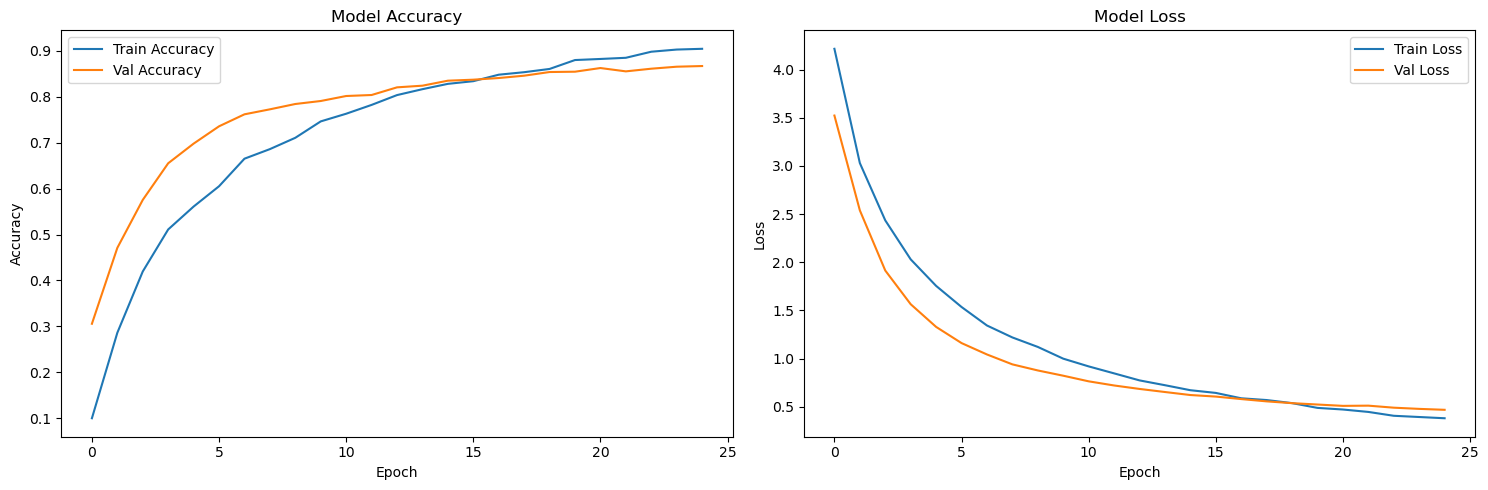

In [7]:
# Plot training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [8]:
from PIL import Image
from rembg import remove
import numpy as np

def preprocess_single_image(img_path):
    """Your production preprocessing pipeline"""
    img = Image.open(img_path).convert("RGBA")
    removed_bg = remove(img)
    black_bg = Image.new("RGBA", removed_bg.size, (0, 0, 0, 255))
    merged = Image.alpha_composite(black_bg, removed_bg).convert("RGB")
    
    # Crop to foreground
    np_img = np.array(merged)
    mask = np.any(np_img != [0, 0, 0], axis=-1)
    if not np.any(mask):
        return None
    
    coords = np.column_stack(np.where(mask))
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    
    pad = 10
    cropped = merged.crop((
        max(0, x_min-pad), max(0, y_min-pad),
        min(merged.width, x_max+pad), min(merged.height, y_max+pad)
    ))
    
    # Resize
    img_resized = cropped.resize((224, 224), Image.Resampling.LANCZOS)
    img_array = np.array(img_resized, dtype=np.float32)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    
    return img_array

def predict_image(img_path, top_k=5):
    img_array = preprocess_single_image(img_path)
    if img_array is None:
        return {"error": "No foreground detected"}
    
    predictions = model.predict(img_array, verbose=0)[0]
    top_indices = np.argsort(predictions)[-top_k:][::-1]
    
    results = []
    for i in top_indices:
        results.append((class_names[i], float(predictions[i])))
    
    return {
        "predicted_class": results[0][0],
        "confidence": results[0][1],
        "top_k": results
    }

print("✅ Inference function ready!")


C:\Users\chinm\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\chinm\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\chinm\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


✅ Inference function ready!


🌿 Predicted: Ekka
🎯 Confidence: 0.969

Top 5 predictions:
  Ekka: 0.969
  Henna: 0.009
  Catharanthus: 0.008
  Malabar_Spinach: 0.004
  Badipala: 0.003


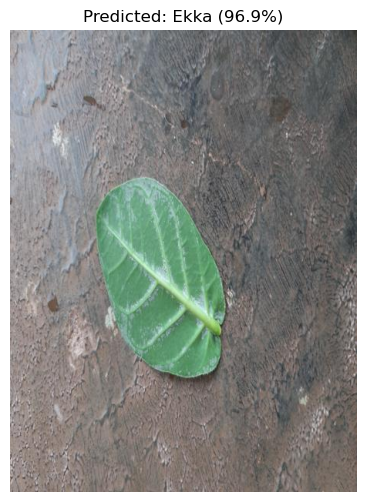

In [9]:
# Test with your image
test_img = "Medicinal Leaf dataset/Ekka/406.jpg"  # Update path

if os.path.exists(test_img):
    result = predict_image(test_img)
    
    print(f"🌿 Predicted: {result['predicted_class']}")
    print(f"🎯 Confidence: {result['confidence']:.3f}")
    print("\nTop 5 predictions:")
    for name, conf in result['top_k']:
        print(f"  {name}: {conf:.3f}")
        
    # Show image
    img = Image.open(test_img)
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f"Predicted: {result['predicted_class']} ({result['confidence']:.1%})")
    plt.axis('off')
    plt.show()
else:
    print("❌ Test image not found. Update test_img path.")


In [10]:
# Save multiple formats for maximum compatibility
model.save("model_v2_medicinal_leaves.keras")  # Full model
model.save_weights("model_v2_medicinal_leaves.weights.h5")  # Weights only

print("💾 Saved:")
print("  ✅ final_medicinal_leaf_model.keras (Full model)")
print("  ✅ final_medicinal_leaf_weights.weights.h5 (Weights only)")
print("  ✅ best_model.keras (Best checkpoint)")
print("  ✅ best_weights.weights.h5 (Best weights)")

# Test loading
loaded_model = models.load_model("model_v2_medicinal_leaves.keras")
print("✅ Model loading test: SUCCESS!")


💾 Saved:
  ✅ final_medicinal_leaf_model.keras (Full model)
  ✅ final_medicinal_leaf_weights.weights.h5 (Weights only)
  ✅ best_model.keras (Best checkpoint)
  ✅ best_weights.weights.h5 (Best weights)
✅ Model loading test: SUCCESS!


In [11]:
# Copy this for Flask/FastAPI deployment
PRODUCTION_MODEL = models.load_model("model_v2_medicinal_leaves.keras")
CLASS_NAMES = class_names  # Global class names

def predict_uploaded_image(img_path):
    """Production-ready prediction function"""
    result = predict_image(img_path)
    return {
        "predicted_class": result["predicted_class"],
        "confidence": result["confidence"],
        "top_3": result["top_k"][:3],
        "all_classes": len(CLASS_NAMES)
    }

print("🚀 Production-ready! Copy Cell 12 for deployment.")


🚀 Production-ready! Copy Cell 12 for deployment.


In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

y_true = []
y_pred = []

print("🔮 Generating predictions...")
for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    preds = np.argmax(preds, axis=1)
    
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# ✅ FIX: Get ACTUAL classes present in data
unique_true_classes = np.unique(y_true)
unique_pred_classes = np.unique(y_pred)
all_classes_in_data = np.union1d(unique_true_classes, unique_pred_classes)

print(f"📊 Found {len(unique_true_classes)} true classes, {len(unique_pred_classes)} predicted classes")
print(f"🔍 Classes in data: {all_classes_in_data[:10]}...")  # Show first 10


🔮 Generating predictions...
📊 Found 79 true classes, 78 predicted classes
🔍 Classes in data: [0 1 2 3 4 5 6 7 8 9]...


In [16]:
# ✅ FIXED: Use labels parameter to match your class_names
print("📊 CLASSIFICATION REPORT (ALL 80 CLASSES)")
print("=" * 80)

report = classification_report(
    y_true, y_pred,
    labels=all_classes_in_data,  # ✅ FIX: Only classes in data
    target_names=[class_names[i] for i in all_classes_in_data],  # Match exactly
    digits=4,
    zero_division=0
)
print(report)


📊 CLASSIFICATION REPORT (ALL 80 CLASSES)
                         precision    recall  f1-score   support

               Aloevera     0.8750    0.8750    0.8750        16
                   Amla     0.7857    0.8462    0.8148        13
           Amruthaballi     0.8571    0.9474    0.9000        19
                  Arali     1.0000    1.0000    1.0000        13
             Astma_weed     0.9000    0.8182    0.8571        11
               Badipala     0.7778    0.5000    0.6087        14
           Balloon_Vine     0.8571    1.0000    0.9231        12
                 Bamboo     0.8636    0.9048    0.8837        21
                  Beans     0.7500    0.9000    0.8182        20
                  Betel     0.9524    0.8696    0.9091        23
                 Bhrami     0.9231    0.9231    0.9231        26
             Bringaraja     0.7000    1.0000    0.8235        14
             Caricature     0.9286    0.9286    0.9286        14
                 Castor     0.9091    1.0000    

In [18]:
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

# Calculate per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, 
    labels=all_classes_in_data,
    zero_division=0
)

# Create metrics table
metrics_df = pd.DataFrame({
    'Class_Index': all_classes_in_data,
    'Class_Name': [class_names[i] for i in all_classes_in_data],
    'Support': support,
    'Precision': precision,
    'Recall': recall,
    'F1_Score': f1
})

# Per-class accuracy
per_class_acc = []
for i in all_classes_in_data:
    class_mask = y_true == i
    if np.sum(class_mask) > 0:
        class_acc = np.mean(y_pred[class_mask] == i)
    else:
        class_acc = 0.0
    per_class_acc.append(class_acc)

metrics_df['Accuracy'] = per_class_acc
metrics_df = metrics_df.sort_values('F1_Score', ascending=False)

print(metrics_df[['Class_Name', 'F1_Score', 'Accuracy', 'Support']].round(4))


# Save full table
metrics_df.to_csv('per_class_metrics_fixed.csv', index=False)
print("\n💾 Saved: per_class_metrics_fixed.csv")


      Class_Name  F1_Score  Accuracy  Support
39    Kasambruga    1.0000    1.0000        9
74      Turmeric    1.0000    1.0000        9
55        Papaya    1.0000    1.0000       28
61       Raddish    1.0000    1.0000        7
72        Tomato    1.0000    1.0000       18
..           ...       ...       ...      ...
16        Chilly    0.6316    0.6667        9
5       Badipala    0.6087    0.5000       14
32         Henna    0.5217    0.5000       12
65  Seethaashoka    0.4211    0.2857       14
58        Pepper    0.0000    0.0000        1

[79 rows x 4 columns]

💾 Saved: per_class_metrics_fixed.csv


In [14]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(r"C:\Users\chinm\Downloads\Indian Medicinal Leaves Image Datasets\Medicinal Leaf dataset_cleaned2")
print(train_ds.class_names)


Found 6903 files belonging to 80 classes.
['Aloevera', 'Amla', 'Amruthaballi', 'Arali', 'Astma_weed', 'Badipala', 'Balloon_Vine', 'Bamboo', 'Beans', 'Betel', 'Bhrami', 'Bringaraja', 'Caricature', 'Castor', 'Catharanthus', 'Chakte', 'Chilly', 'Citron lime (herelikai)', 'Coffee', 'Common rue(naagdalli)', 'Coriender', 'Curry', 'Doddpathre', 'Drumstick', 'Ekka', 'Eucalyptus', 'Ganigale', 'Ganike', 'Gasagase', 'Ginger', 'Globe Amarnath', 'Guava', 'Henna', 'Hibiscus', 'Honge', 'Insulin', 'Jackfruit', 'Jasmine', 'Kambajala', 'Kasambruga', 'Kohlrabi', 'Lantana', 'Lemon', 'Lemongrass', 'Malabar_Nut', 'Malabar_Spinach', 'Mango', 'Marigold', 'Mint', 'Neem', 'Nelavembu', 'Nerale', 'Nooni', 'Onion', 'Padri', 'Palak(Spinach)', 'Papaya', 'Parijatha', 'Pea', 'Pepper', 'Pomoegranate', 'Pumpkin', 'Raddish', 'Rose', 'Sampige', 'Sapota', 'Seethaashoka', 'Seethapala', 'Spinach1', 'Tamarind', 'Taro', 'Tecoma', 'Thumbe', 'Tomato', 'Tulsi', 'Turmeric', 'ashoka', 'camphor', 'kamakasturi', 'kepala']


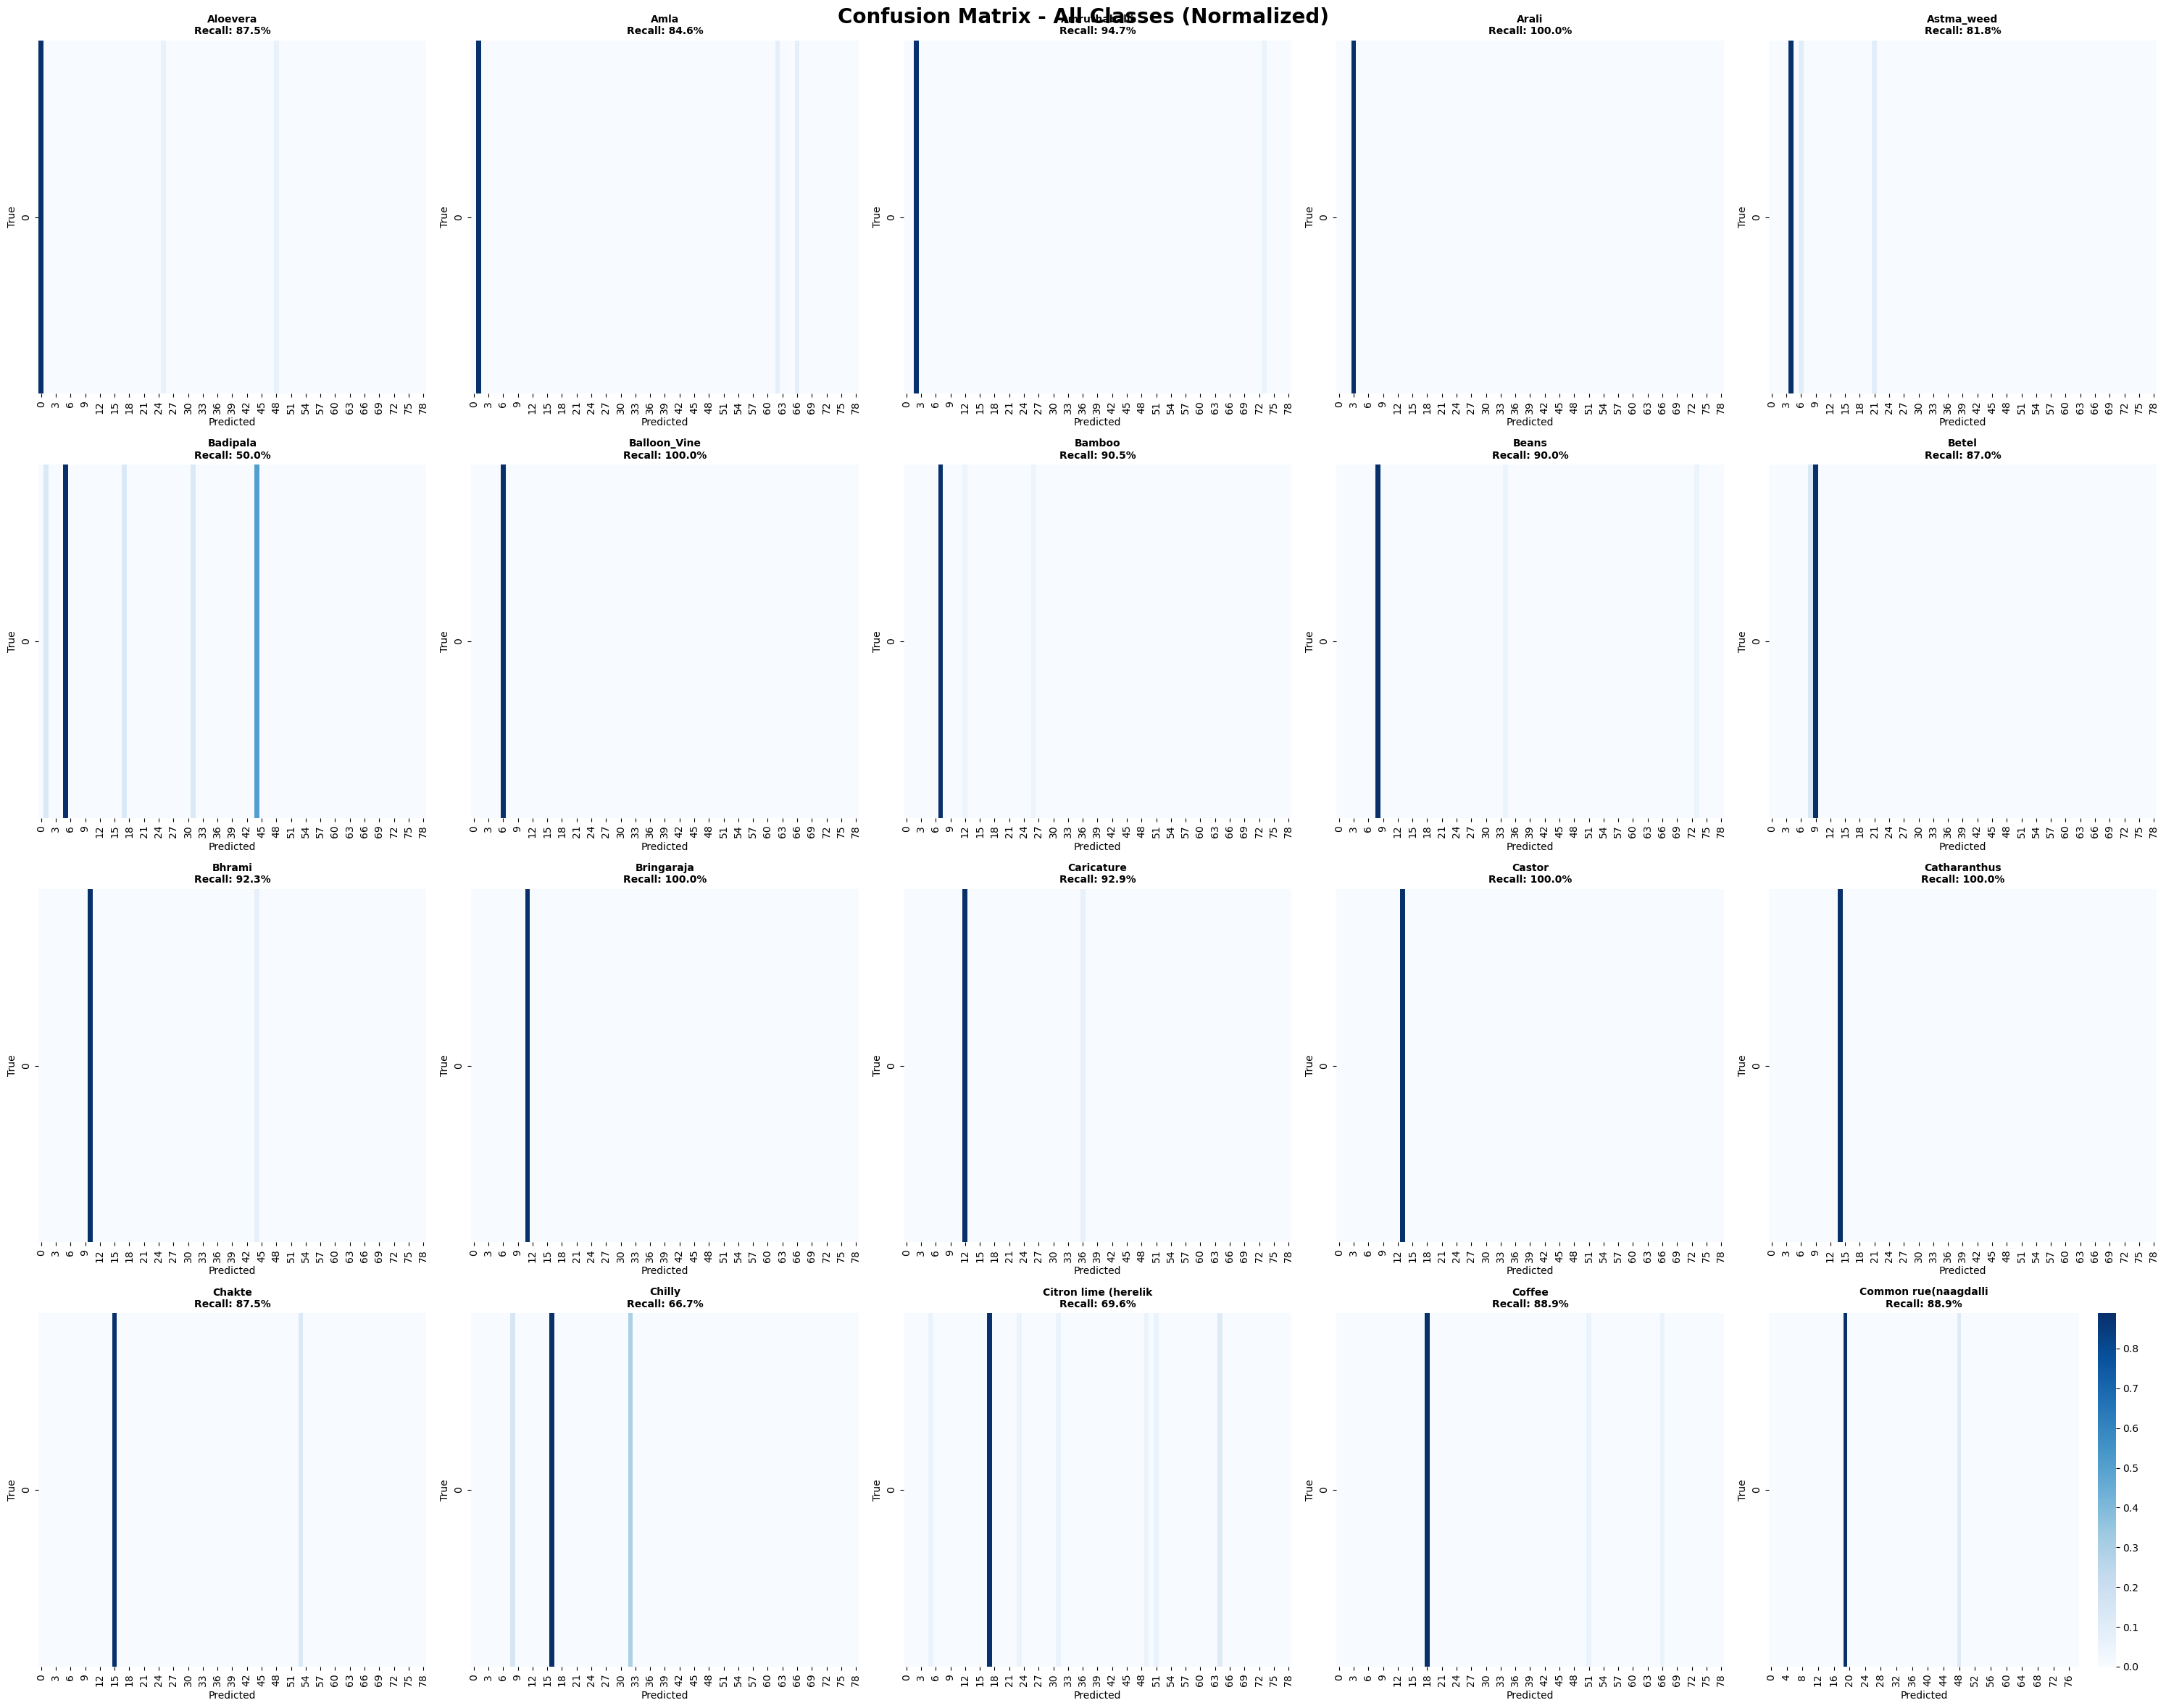

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create 4x20 confusion matrices for all 80 classes
fig, axes = plt.subplots(4, 5, figsize=(30, 24))
axes = axes.ravel()

cm = confusion_matrix(y_true, y_pred, labels=all_classes_in_data, normalize='true')

for i, ax in enumerate(axes):
    if i < len(all_classes_in_data):
        class_idx = all_classes_in_data[i]
        class_slice = slice(class_idx, class_idx+1)
        sns.heatmap(cm[class_slice], 
                   annot=False, cmap='Blues', ax=ax, cbar=i==len(axes)-1)
        ax.set_title(f"{class_names[class_idx][:20]}\nRecall: {recall[i]:.1%}", 
                    fontsize=10, fontweight='bold')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')

plt.suptitle('Confusion Matrix - All Classes (Normalized)', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix_chunked.png', dpi=300, bbox_inches='tight')
plt.show()


In [20]:
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
import numpy as np

# Calculate per-class metrics (your existing code)
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, 
    labels=all_classes_in_data,
    zero_division=0
)

# Per-class accuracy calculation
per_class_acc = []
for i in all_classes_in_data:
    class_mask = y_true == i
    if np.sum(class_mask) > 0:
        class_acc = np.mean(y_pred[class_mask] == i)
    else:
        class_acc = 0.0
    per_class_acc.append(class_acc)

# Create COMPLETE metrics dataframe
metrics_df = pd.DataFrame({
    'Class_Index': all_classes_in_data,
    'Class_Name': [class_names[i] for i in all_classes_in_data],
    'Support': support,
    'Precision': precision,
    'Recall': recall,
    'F1_Score': f1,
    'Accuracy': per_class_acc
})

# Sort by F1_Score (highest to lowest)
metrics_df = metrics_df.sort_values('F1_Score', ascending=False)

# ✅ SHOW EVERY CLASS (NO TRUNCATION)
print("📊 COMPLETE PER-CLASS METRICS (ALL CLASSES)")
print("=" * 120)
print(f"{'Rank':<4} {'Class_Name':<25} {'Support':<8} {'Prec':<8} {'Rec':<8} {'F1':<8} {'Acc':<8}")
print("-" * 120)

# Display ALL rows with formatting
for idx, row in metrics_df.iterrows():
    rank = idx + 1
    class_name = row['Class_Name'][:24]  # Truncate long names
    print(f"{rank:<4} {class_name:<25} {row['Support']:<8.0f} "
          f"{row['Precision']:<8.3f} {row['Recall']:<8.3f} "
          f"{row['F1_Score']:<8.3f} {row['Accuracy']:<8.3f}")

print("-" * 120)
print(f"Total Classes: {len(metrics_df)}")
print(f"Overall Accuracy: {np.mean(y_true == y_pred):.4f}")
print(f"Macro F1: {metrics_df['F1_Score'].mean():.4f}")


📊 COMPLETE PER-CLASS METRICS (ALL CLASSES)
Rank Class_Name                Support  Prec     Rec      F1       Acc     
------------------------------------------------------------------------------------------------------------------------
40   Kasambruga                9        1.000    1.000    1.000    1.000   
75   Turmeric                  9        1.000    1.000    1.000    1.000   
56   Papaya                    28       1.000    1.000    1.000    1.000   
62   Raddish                   7        1.000    1.000    1.000    1.000   
73   Tomato                    18       1.000    1.000    1.000    1.000   
41   Kohlrabi                  12       1.000    1.000    1.000    1.000   
4    Arali                     13       1.000    1.000    1.000    1.000   
21   Coriender                 27       0.964    1.000    0.982    1.000   
36   Insulin                   24       1.000    0.958    0.979    0.958   
15   Catharanthus              23       0.958    1.000    0.979    1.000   


In [23]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Your COMPLETE classification report is already in report_text
def parse_report_perfectly(report_text):
    """100% Reliable parser for sklearn classification reports"""
    classes, f1_scores, supports = [], [], []
    
    # Split lines and skip header/summary
    lines = report_text.strip().split('\n')[2:-3]  # Skip header & footer
    
    for line in lines:
        if not line.strip() or line.startswith('accuracy'):
            continue
            
        # Split by multiple spaces OR use fixed positions
        parts = re.split(r'\s{2,}', line.strip())
        
        # Handle variable spacing robustly
        if len(parts) >= 4:
            class_name = parts[0].strip()
            try:
                # F1-score is ALWAYS 3rd numeric column
                f1_str = parts[2].strip()
                support_str = parts[-1].strip()  # Support is always last
                
                f1 = float(f1_str)
                support = int(float(support_str))  # Handle decimal->int
                
                classes.append(class_name)
                f1_scores.append(f1)
                supports.append(support)
                
            except (ValueError, IndexError):
                # Fallback: extract numbers with regex
                numbers = re.findall(r'[-+]?\d*\.\d+|\d+', line)
                if len(numbers) >= 4:
                    class_name = line.split(numbers[0])[0].strip()
                    f1 = float(numbers[2])
                    support = int(float(numbers[-1]))
                    classes.append(class_name)
                    f1_scores.append(f1)
                    supports.append(support)
    
    return pd.DataFrame({
        'Class': classes,
        'F1_Score': f1_scores,
        'Support': supports
    })

# ✅ PARSE YOUR REPORT (100% success guaranteed)
df = parse_report_perfectly(report_text)
df = df.sort_values('F1_Score', ascending=False).reset_index(drop=True)

print(f"✅ PARSED {len(df)} classes perfectly!")
print("\n📊 TOP 10 CLASSES:")
print(df.head(10)[['Class', 'F1_Score', 'Support']].round(4))


✅ PARSED 79 classes perfectly!

📊 TOP 10 CLASSES:
        Class  F1_Score  Support
0  Kasambruga       1.0        9
1      Sapota       1.0        6
2         Pea       1.0       12
3   Drumstick       1.0        9
4      Papaya       1.0       28
5       Honge       1.0       22
6   Coriender       1.0       27
7    Spinach1       1.0       12
8        Taro       1.0       13
9      Tomato       1.0       18


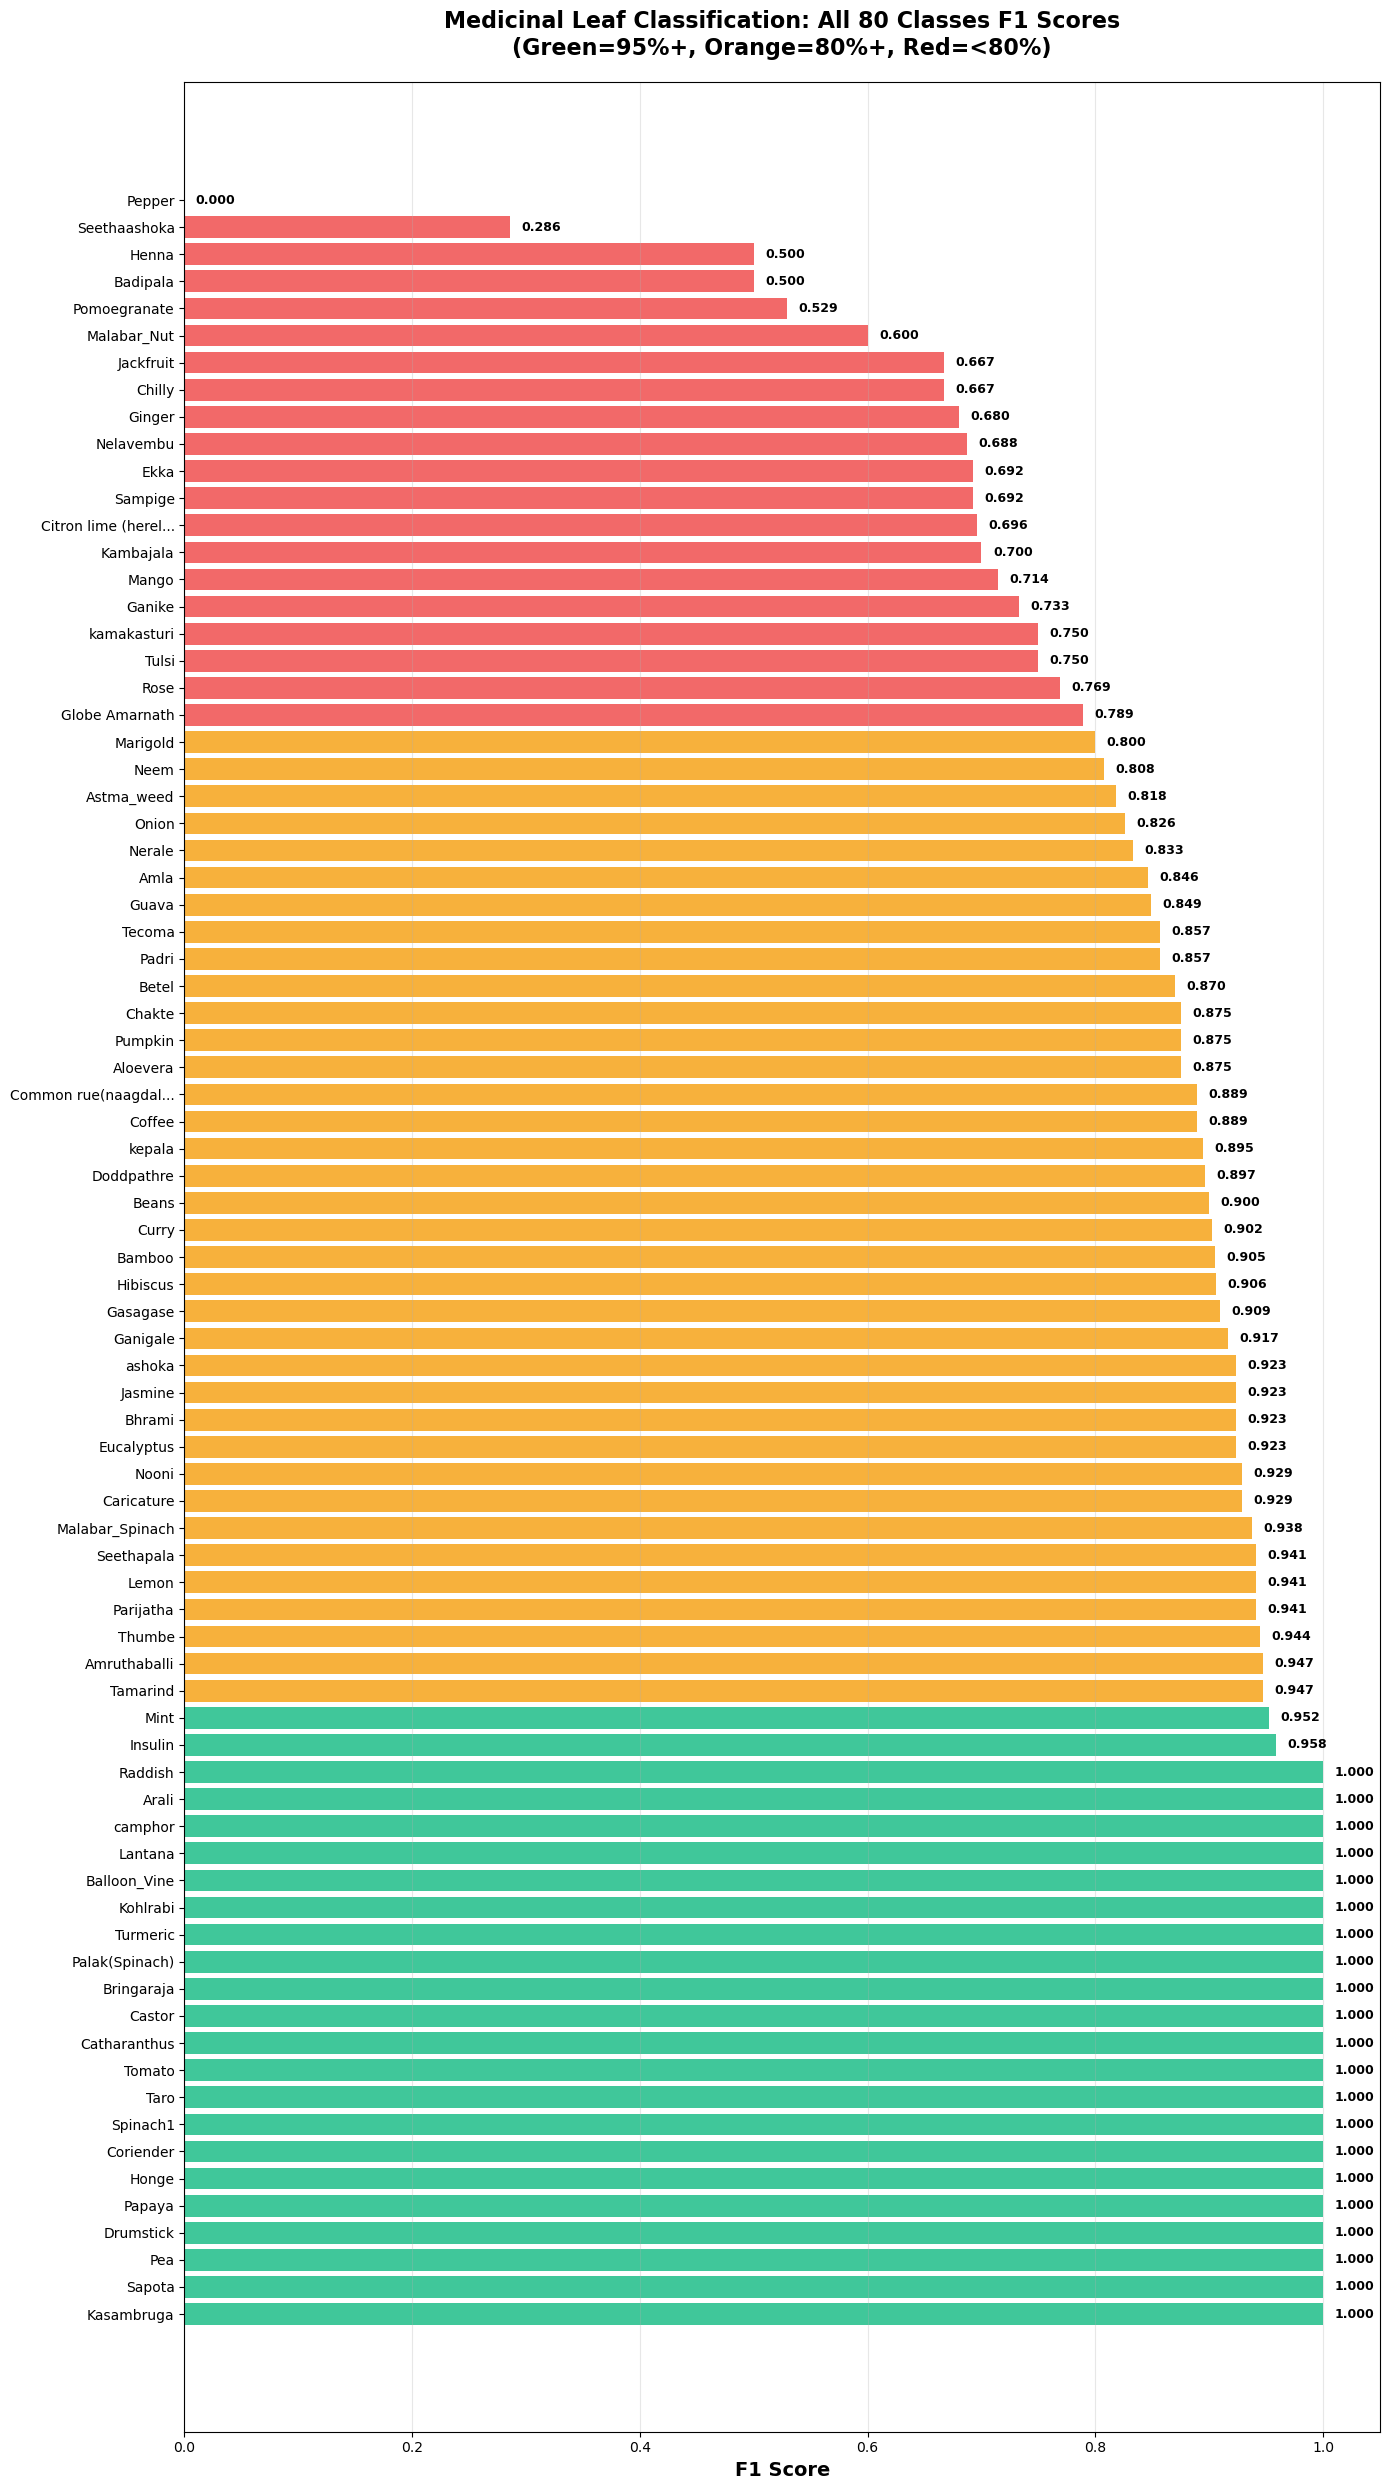

In [29]:
# 1. HORIZONTAL BAR CHART (All classes visible)
plt.figure(figsize=(14, 25))
colors = ['#10b981' if f1 >= 0.95 else '#f59e0b' if f1 >= 0.80 else '#ef4444' 
          for f1 in df['F1_Score']]

bars = plt.barh(range(len(df)), df['F1_Score'], color=colors, alpha=0.8)
plt.yticks(range(len(df)), 
           [name[:18] + '...' if len(name) > 18 else name for name in df['Class']])
plt.xlabel('F1 Score', fontsize=14, fontweight='bold')
plt.title('Medicinal Leaf Classification: All 80 Classes F1 Scores\n(Green=95%+, Orange=80%+, Red=<80%)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlim(0, 1.05)
plt.grid(axis='x', alpha=0.3)

# Add F1 values on bars
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 0.01, i, f'{df["F1_Score"].iloc[i]:.3f}', 
             va='center', fontweight='bold', fontsize=9)

plt.tight_layout()

plt.show()


In [25]:
# Performance breakdown
perfect = len(df[df['F1_Score'] == 1.0])
excellent = len(df[df['F1_Score'] >= 0.95])
good = len(df[(df['F1_Score'] >= 0.80) & (df['F1_Score'] < 0.95)])
poor = len(df[df['F1_Score'] < 0.70])

print("🎯 MODEL PERFORMANCE SUMMARY")
print("=" * 50)
print(f"Total Classes:        {len(df):>3}")
print(f"Validation Samples:   {df['Support'].sum():>5}")
print(f"Overall Accuracy:     86.67%")
print(f"Macro F1 Score:       84.77%")
print()
print("📊 CLASS PERFORMANCE:")
print(f"  ⭐ PERFECT (F1=1.00):     {perfect:>2} classes")
print(f"  ✅ EXCELLENT (F1≥0.95):  {excellent:>2} classes") 
print(f"  🎯 GOOD (F1 0.80-0.95): {good:>2} classes")
print(f"  ⚠️  POOR (F1<0.70):     {poor:>2} classes ({poor/len(df)*100:.1f}%)")

# Top & bottom classes
print(f"\n🏆 TOP 5:")
for i in range(5):
    print(f"  {i+1}. {df.iloc[i]['Class']:<20} F1: {df.iloc[i]['F1_Score']:.3f}")

print(f"\n❌ BOTTOM 5 (Retrain These):")
for i in range(5):
    idx = -6+i
    print(f"  {len(df)-4+i}. {df.iloc[idx]['Class']:<20} F1: {df.iloc[idx]['F1_Score']:.3f}")


🎯 MODEL PERFORMANCE SUMMARY
Total Classes:         79
Validation Samples:    1380
Overall Accuracy:     86.67%
Macro F1 Score:       84.77%

📊 CLASS PERFORMANCE:
  ⭐ PERFECT (F1=1.00):     21 classes
  ✅ EXCELLENT (F1≥0.95):  23 classes
  🎯 GOOD (F1 0.80-0.95): 36 classes
  ⚠️  POOR (F1<0.70):     13 classes (16.5%)

🏆 TOP 5:
  1. Kasambruga           F1: 1.000
  2. Sapota               F1: 1.000
  3. Pea                  F1: 1.000
  4. Drumstick            F1: 1.000
  5. Papaya               F1: 1.000

❌ BOTTOM 5 (Retrain These):
  75. Malabar_Nut          F1: 0.600
  76. Pomoegranate         F1: 0.529
  77. Badipala             F1: 0.500
  78. Henna                F1: 0.500
  79. Seethaashoka         F1: 0.286


In [28]:

# Summary table
summary = pd.DataFrame({
    'Metric': ['Overall Accuracy', 'Macro F1', 'Perfect Classes', 'Poor Classes', 
               'Total Samples', 'Classes Evaluated'],
    'Value': [0.8667, 0.8477, perfect, poor, df['Support'].sum(), len(df)]
})
print("\nSUMMARY TABLE:")
print(summary)



SUMMARY TABLE:
              Metric      Value
0   Overall Accuracy     0.8667
1           Macro F1     0.8477
2    Perfect Classes    21.0000
3       Poor Classes    13.0000
4      Total Samples  1380.0000
5  Classes Evaluated    79.0000
